In [115]:
# Usual Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn

from IPython.lib.deepreload import reload as dreload

# Librosa (the mother of audio files)
import librosa
import librosa.display
import IPython.display as ipd
import warnings
warnings.filterwarnings('ignore')

from data_preprocessing import *
from data_analysis import *
from helpers import *
import os
from os import path
import numpy as np
import pickle
import itertools
import librosa
import pandas as pd
from scipy.stats import kurtosis
from scipy.stats import skew
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier, XGBRFClassifier
from xgboost import plot_tree, plot_importance

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score,f1_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier

fileName = "features.dat"

data = load_binaryfile(fileName)

print("done loading")


done loading


In [8]:
y = data.classlabel
X = data.drop('classlabel',axis=1)

cols = X.columns
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(X)

X = pd.DataFrame(np_scaled, columns = cols)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [9]:
def model_assess(model, title = "Default"):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    score = accuracy_score(y_test, preds) * 100 #* 100 for procent
    print(f'Accuracy {title} : {score:4.3f}%\n')

In [10]:
nb = GaussianNB()
model_assess(nb, "Naive Bayes")

sgd = SGDClassifier()
model_assess(sgd, "Stochastic Gradient Descent")

knn = KNeighborsClassifier()
model_assess(knn, "KNN")

tree = DecisionTreeClassifier()
model_assess(tree, "Decission trees")

rforest = RandomForestClassifier()
model_assess(rforest, "Random Forest")

svm = SVC()
model_assess(svm, "Support Vector Machine")

lg = LogisticRegression()
model_assess(lg, "Logistic Regression")

nn = MLPClassifier()
model_assess(nn, "Neural Nets")

grad = GradientBoostingClassifier()
model_assess(grad,"Gradient boost")

#Hist klart bedste score - men experimental, så på nuværende ikke "fremtids sikker"
hist = HistGradientBoostingClassifier()
model_assess(hist,"Hist gradient boost")

xgb = XGBClassifier()
model_assess(xgb, "Cross Gradient Booster")

Accuracy Naive Bayes : 38.172%

Accuracy Stochastic Gradient Descent : 54.087%

Accuracy KNN : 78.345%

Accuracy Decission trees : 66.400%

Accuracy Random Forest : 83.217%

Accuracy Support Vector Machine : 59.459%

Accuracy Logistic Regression : 57.624%

Accuracy Neural Nets : 64.231%

Accuracy Gradient boost : 78.111%

Accuracy Hist gradient boost : 87.988%

Accuracy Cross Gradient Booster : 86.486%



In [11]:
from sklearn.model_selection import GridSearchCV

model = XGBClassifier()

params = [{
    'eta':[1e-5,1e-3,1e-1,1],
    'max_depth':[5,10,20,40,100],
    'subsample':[0.5,1],
    'sampling_method':['uniform'],
    'tree_method':['exact','approx','hist'],
    'grow_policy':['depthwise','lossguide']
}]
#Findes flere sampling måder - men virker kun GPU based
#subsample < 1, skulle gerne skal tjek for overfitting.
#Eta = learning rate.

grid_tuned = GridSearchCV(estimator=model,
                         param_grid=params,
                         cv=10,
                         scoring='f1_micro',
                         verbose=False,
                         iid=True,
                         n_jobs=-1)

grid_tuned.fit(X_train,y_train)


GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_job...
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, validate_parameters=None,
                                     verbosity=None),
  

In [13]:
print("best params:",grid_tuned.best_params_)
print("model scoring:",grid_tuned.scoring)
print("best score:",grid_tuned.best_score_)
try:
    print("mean score:",grid_tuned.cv_results_['mean_test_score'])
    print("std score:",grid_tuned.cv_results_['std_test_score'])
except:
    print("Random error 42.")

best params: {'eta': 0.1, 'grow_policy': 'depthwise', 'max_depth': 10, 'sampling_method': 'uniform', 'subsample': 1, 'tree_method': 'approx'}
model scoring: f1_micro
best score: 0.8376948376948377
mean score: [0.64593165 0.64292864 0.64078364 0.58458458 0.58415558 0.58329758
 0.73459173 0.73859574 0.73773774 0.65508366 0.66394966 0.65880166
 0.74259974 0.74545975 0.74360074 0.65694266 0.67739168 0.66852567
 0.74259974 0.74545975 0.74360074 0.65694266 0.67739168 0.66852567
 0.74259974 0.74545975 0.74360074 0.65694266 0.67739168 0.66852567
 0.64593165 0.64292864 0.64078364 0.58458458 0.58415558 0.58329758
 0.73459173 0.73859574 0.73773774 0.65508366 0.66394966 0.65880166
 0.74259974 0.74545975 0.74360074 0.65694266 0.67739168 0.66852567
 0.74259974 0.74545975 0.74360074 0.65694266 0.67739168 0.66852567
 0.74259974 0.74545975 0.74360074 0.65694266 0.67739168 0.66852567
 0.64864865 0.64550265 0.64578865 0.60589161 0.61718862 0.6027456
 0.73788074 0.74188474 0.73830974 0.68396968 0.72615473

In [37]:
#best model / easy stopping
eval_set = [(X_test,y_test)]
model = XGBClassifier(eta = 0.1,
                      grow_policy = 'depthwise',max_depth = 10,
                      sampling_method = 'uniform',
                      subsample = 1,
                      tree_method = 'approx'
                     )

model.fit(X_train,y_train,early_stopping_rounds=10,eval_metric="merror",eval_set=eval_set,verbose=True)
results = model.evals_result()
print(results)

[0]	validation_0-merror:0.31698
Will train until validation_0-merror hasn't improved in 10 rounds.
[1]	validation_0-merror:0.27661
[2]	validation_0-merror:0.24925
[3]	validation_0-merror:0.24424
[4]	validation_0-merror:0.23223
[5]	validation_0-merror:0.22723
[6]	validation_0-merror:0.21989
[7]	validation_0-merror:0.21655
[8]	validation_0-merror:0.21054
[9]	validation_0-merror:0.20587
[10]	validation_0-merror:0.20287
[11]	validation_0-merror:0.20320
[12]	validation_0-merror:0.19853
[13]	validation_0-merror:0.19620
[14]	validation_0-merror:0.19286
[15]	validation_0-merror:0.19586
[16]	validation_0-merror:0.19486
[17]	validation_0-merror:0.19419
[18]	validation_0-merror:0.18952
[19]	validation_0-merror:0.18986
[20]	validation_0-merror:0.18752
[21]	validation_0-merror:0.18552
[22]	validation_0-merror:0.18552
[23]	validation_0-merror:0.18652
[24]	validation_0-merror:0.18485
[25]	validation_0-merror:0.18318
[26]	validation_0-merror:0.18252
[27]	validation_0-merror:0.18285
[28]	validation_0-m

In [48]:
preds = model.predict(X_test)
Acc_score = accuracy_score(y_test, preds) * 100 #* 100 for procent
print(f'Accuracy : {Acc_score:.3f}%\n')

f1_micro: 85.519%

Accuracy : 85.519%

Precision : 85.519%

Recall : 85.519%



[[264   1  27   8   1   5   3   1   6   3]
 [  0 295   1   0   0   7   0   1   1   3]
 [ 21   1 225   7   0  19   2   2   5   7]
 [  3   0  13 249   6   1   4  14   6   5]
 [  6   0   6   6 268   0   4  10   7   3]
 [  4  16  15   0   0 246   1   1   0   0]
 [  2   2   5   0   4   1 277   1   2   9]
 [  1   0  10   7   4   4   1 232   5   4]
 [  4   2   9   6   5   7   1   4 271   6]
 [  6   4  18  13   1   3  11   3   6 236]]


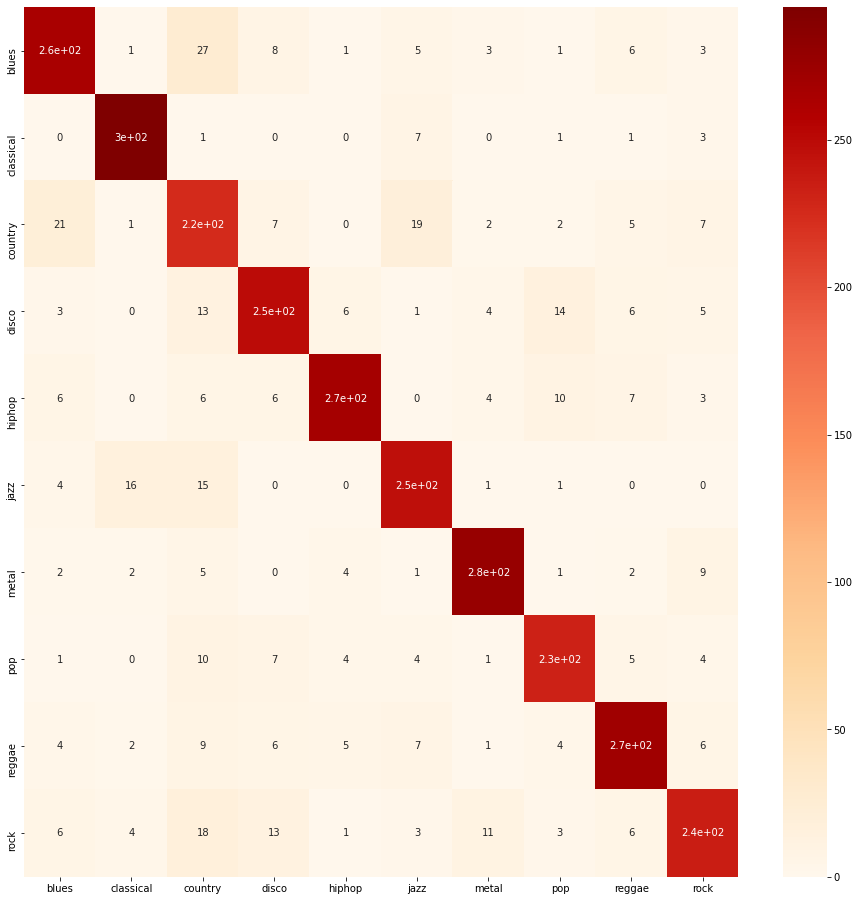

In [76]:
#Confusion matrix
#Seaborn for pretty heatmap :D
import seaborn as sns 
#https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea


conf_m = confusion_matrix(y_test,preds)
print(conf_m)

plt.figure(figsize = (16,16))
labels = ["blues", "classical", "country", "disco","hiphop", "jazz", "metal", "pop", "reggae", "rock"] 
sns.heatmap(conf_m,annot=True,cmap='OrRd',xticklabels=labels,yticklabels=labels)

In [117]:
pathtofile = "C:/Users/jonas/AU/s5/MAL/opgaver/jazz2.wav"
y, sr = librosa.load(pathtofile,duration=30)

    #Removing silence
y_trimmed,_ = librosa.effects.trim(y)
                
    #zero crossing
zeroX = librosa.feature.zero_crossing_rate(y_trimmed,pad=False)
zeroX_mean = zeroX.mean()
zeroX_var = zeroX.var()
                
                
    #harmony & perceptrual
harm, perc = librosa.effects.hpss(y_trimmed)
harm_mean = harm.mean()
harm_var = harm.var()
perc_mean = perc.mean()
perc_var = perc.var()
                
    #Tempo
tempo,_ = librosa.beat.beat_track(y=y,sr=sr)
               
    #Centroid
centroid = librosa.feature.spectral_centroid(y=y_trimmed,sr=sr)[0]
centroid_mean = centroid.mean()
centroid_var = centroid.var()
                
    #Rolloff
rolloff = librosa.feature.spectral_rolloff(y=y_trimmed,sr=sr)[0]
rolloff_mean = rolloff.mean()
rolloff_var = rolloff.var()
                
    #Chroma frequencies
chroma = librosa.feature.chroma_stft(y=y_trimmed,sr=sr)
chroma_mean = chroma.mean()
chroma_var = chroma.var()
            
    #RMS
rms = librosa.feature.rms(y)
rms_mean = rms.mean()
rms_var = rms.var()
            
    #spectral bandwidth
bandwidth = librosa.feature.spectral_bandwidth(y,sr)
bandwidth_mean = bandwidth.mean()
bandwidth_var = bandwidth.var()
            

            
    # MFCC treatment
for i in range(20):
    mfcc  = librosa.feature.mfcc(y, sr, n_mfcc=i+1)
    mfcc_mean = mfcc.mean()
    mfcc_var = mfcc.var()
    feat1 = f"mfcc{i+1}_mean"
    feat2 = f"mfcc{i+1}_var"
    features[feat1].append(np.mean(mfcc_mean))
    features[feat2].append(np.mean(mfcc_var))
            

                
                
        #adding features
features['classlabel'].append("")
features['zero_crossing_mean'].append(zeroX_mean)
features['zero_crossing_var'].append(zeroX_var)
features['harmony_mean'].append(harm_mean)
features['harmony_var'].append(harm_var)
features['perceptrual_mean'].append(perc_mean)
features['perceptrual_var'].append(perc_var)
features['tempo'].append(tempo)
features['centroid_mean'].append(centroid_mean)
features['centroid_var'].append(centroid_var)
features['rolloff_mean'].append(rolloff_mean)
features['rolloff_var'].append(rolloff_mean)
features['chroma_stft_mean'].append(chroma_mean)
features['chroma_stft_var'].append(chroma_var)
features['rms_mean'].append(rms_mean)
features['rms_var'].append(rms_var)
features['bandwidth_mean'].append(bandwidth_mean)
features['bandwidth_var'].append(bandwidth_var)
        
        
df = pd.DataFrame(features)



df = get_feat(pathtofile)
label = df.classlabel
to_test = df.drop('classlabel',axis=1)

cols = X.columns
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(to_test)

to_test = pd.DataFrame(np_scaled, columns = cols)



NotImplementedError: 

In [113]:
pred = model.predict(to_test)

print(pred)

NameError: name 'to_test' is not defined